## Прогнозирование уровня средней заработной платы в России

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Стандартный алгоритм построения прогноза:  
1. Визуальный анализ ряда
1. Стабилизация дисперсии (при необходимости)
1. Выбор порядка дифференцирования
1. Выбор начальных приближений для p, q, P, Q
1. Обучение и сравнение моделей-кандидатов, выбор победителя
1. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.
1. Прогнозирование с помощью финальной модели.  
Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [34]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


**1.** Визуальный анализ ряда

<Figure size 1080x504 with 0 Axes>

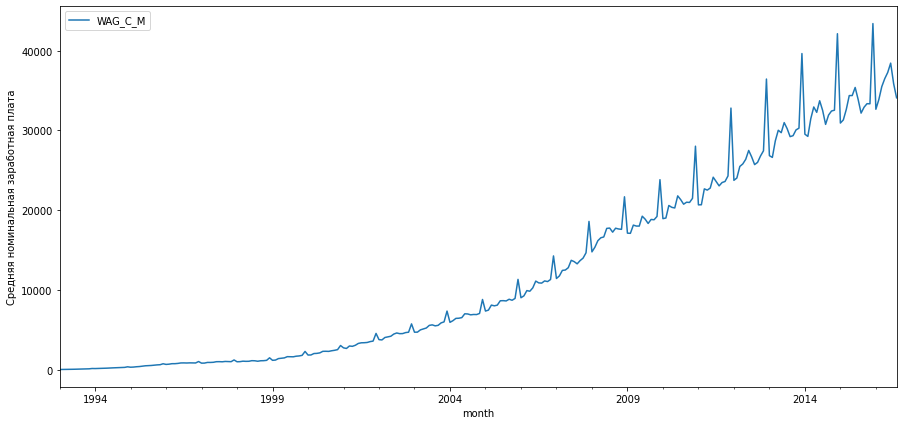

In [2]:
wag_c_m = pd.read_csv("data\WAG_C_M.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wag_c_m.plot()
plt.ylabel("Средняя номинальная заработная плата")
plt.show()

**2.** Стабилизация дисперсии (при необходимости)

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


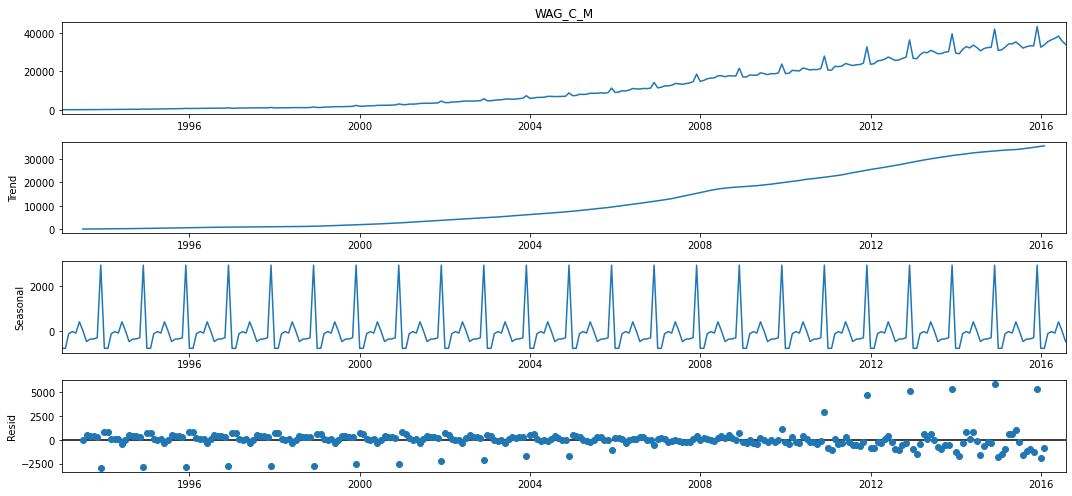

In [3]:
sm.tsa.seasonal_decompose(wag_c_m["WAG_C_M"]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m["WAG_C_M"])[1])

По критерию Дики-Фуллера гипотеза о нестационарности ряда не отвергается.

Сразу видны следующие особенности данных:
* возрастающий тренд
* растущая со временем дисперсия
* периодичность (период - 12 месяцев)
* заметная структура остатков

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


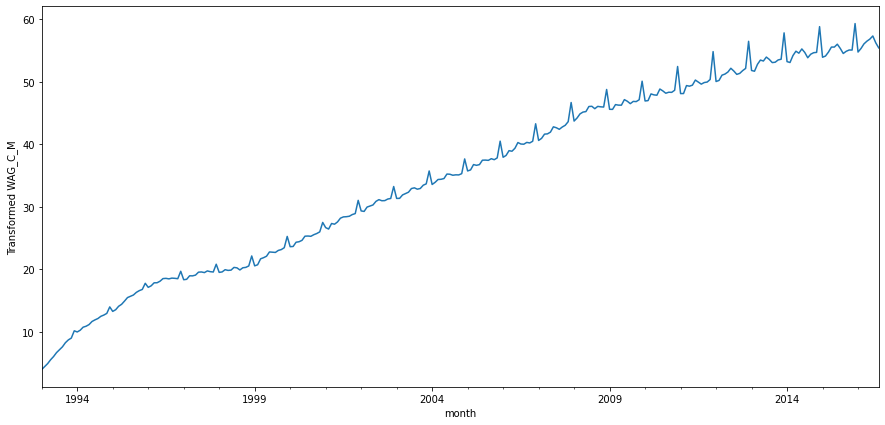

In [4]:
wag_c_m["WAG_C_M_box"], lmbda = stats.boxcox(wag_c_m["WAG_C_M"])
plt.figure(figsize(15,7))
wag_c_m["WAG_C_M_box"].plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m["WAG_C_M_box"])[1])

**3.** Выбор порядка дифференцирования

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

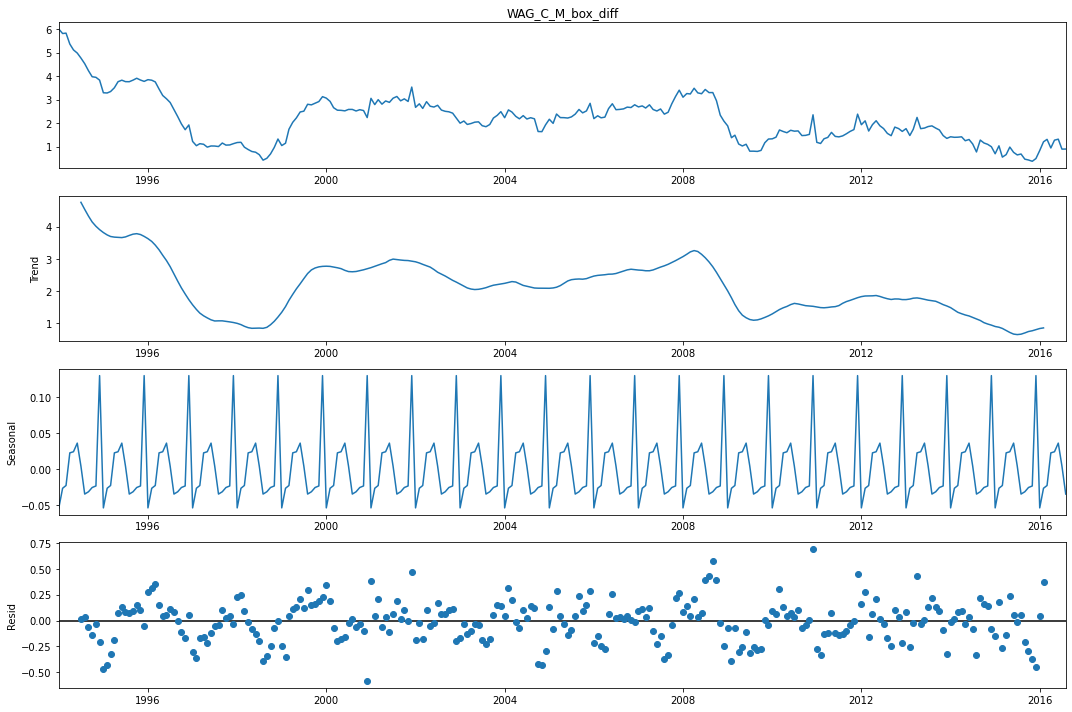

In [5]:
wag_c_m["WAG_C_M_box_diff"] = wag_c_m["WAG_C_M_box"] - wag_c_m["WAG_C_M_box"].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag_c_m["WAG_C_M_box_diff"][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m["WAG_C_M_box_diff"][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но сезонное диффиринцирование не помогло полностью избавиться от тренда. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

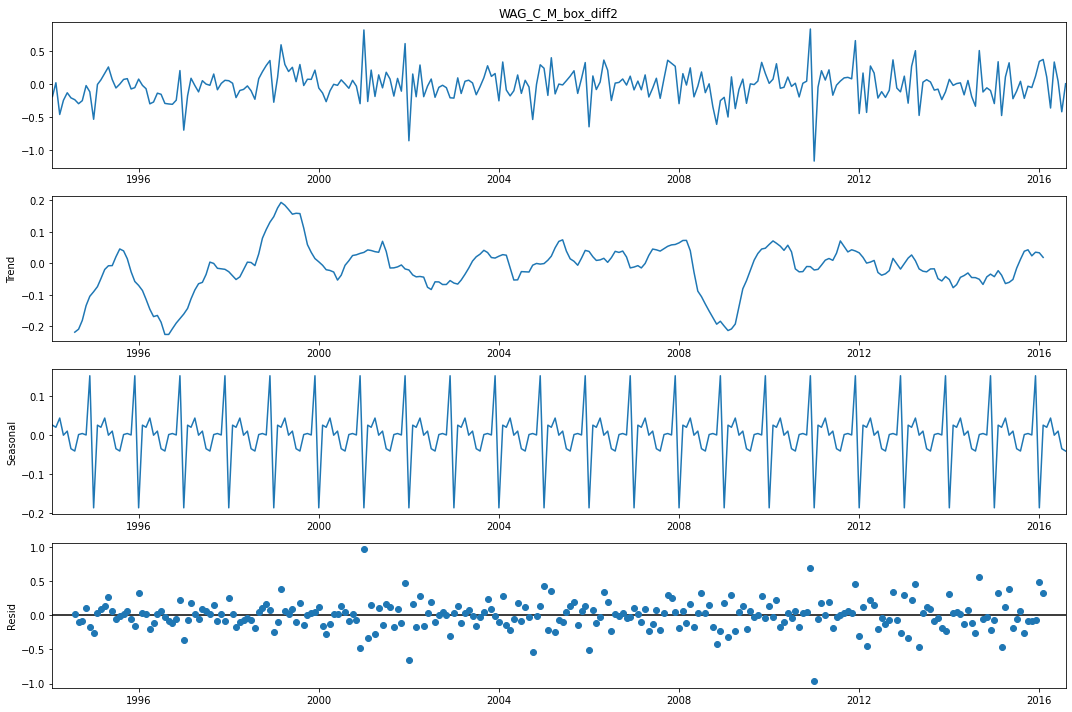

In [6]:
wag_c_m["WAG_C_M_box_diff2"] = wag_c_m["WAG_C_M_box_diff"] - wag_c_m["WAG_C_M_box_diff"].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag_c_m["WAG_C_M_box_diff2"][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag_c_m["WAG_C_M_box_diff2"][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

**4.** Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда:

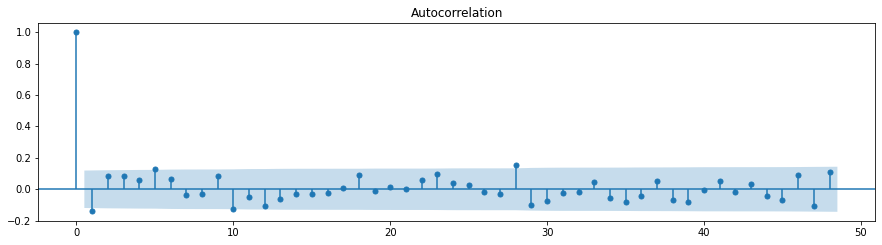

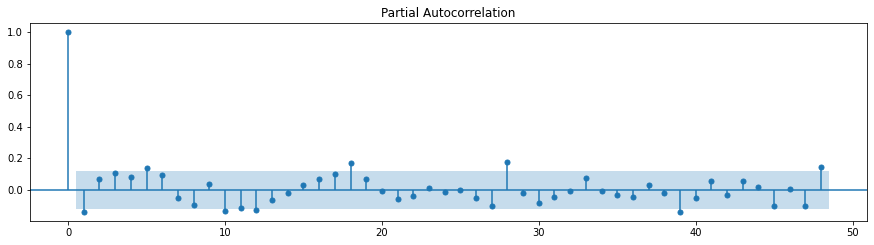

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag_c_m["WAG_C_M_box_diff2"][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag_c_m["WAG_C_M_box_diff2"][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выбираем параметры нашей модели:

__Q__ - значение последнего значимого сезонного лага на автокоррелограмме. Т.к. значимых лагов, кратных периоду (12) нет, то __Q = 0__

__q__ - значение последнего значимого несезонного лага на автокоррелограмме. __q = 1__

__P__ - значение последнего значимого сезонного лага на частичной автокоррелограмме. В данном случае это лаг = 12, поэтому возьмем значение __P = 1__

__p__ - значение последнего значимого несезонного лага, меньшего величин периода, на частичной автокоррелограмме. __p = 1__


Начальные приближения: Q=0, q=1, P=1, p=1

In [35]:
ps = range(0, 2)
d=1
qs = range(0, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [36]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

**5.** Обучение и сравнение моделей-кандидатов, выбор победителя 

In [37]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag_c_m["WAG_C_M_box"], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 19.3 s


In [38]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
30  (1, 3, 1, 0) -10.574815
31  (1, 3, 1, 1)  -9.922888
29  (1, 3, 0, 1)  -9.693763
26  (1, 2, 1, 0)  -8.134236
25  (1, 2, 0, 1)  -7.464917


Лучшая модель:

In [39]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 3)x(1, 1, [], 12)   Log Likelihood                  11.287
Date:                             Tue, 04 Jan 2022   AIC                            -10.575
Time:                                     20:30:52   BIC                             11.038
Sample:                                 01-01-1993   HQIC                            -1.897
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7785      0.125      6.220      0.000       0.533       1.024
ma.L1         -1.0047      

**6.** Анализ остатков построенной модели

Критерий Стьюдента: p=0.280474
Критерий Дики-Фуллера: p=0.000000


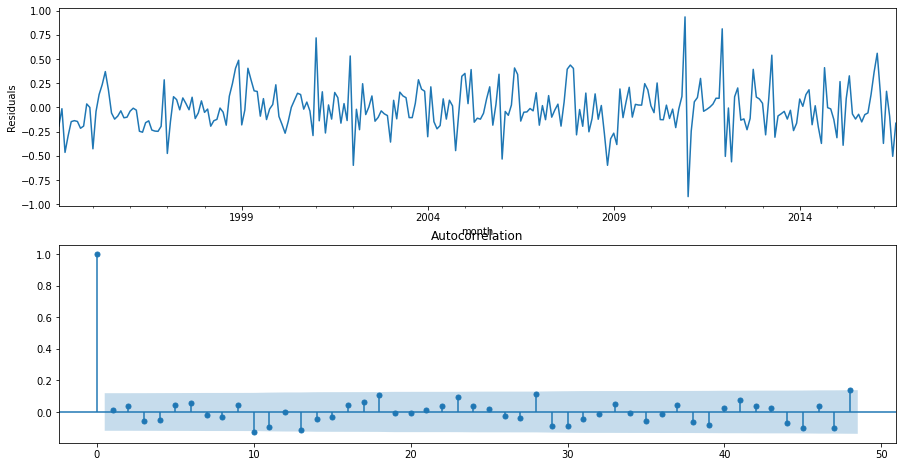

In [40]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

* Остатки несмещены (подтверждается критерием Стьюдента p = 0.28 > 0.05)
* Остатки стационарны (подтверждается критерием Дики-Фуллера p < 0.05 и визуально)
* Остатки неавтокоррелированы (подтверждается критерием Льюнга-Бокса p = 0.64 > 0.05 и коррелограммой).  
Посмотрим, насколько хорошо модель описывает данные:

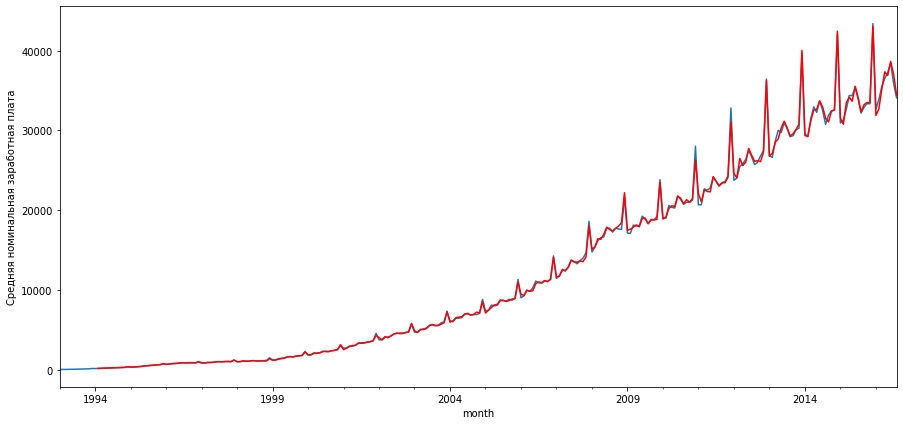

In [46]:
wag_c_m["model"]= invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag_c_m["WAG_C_M"].plot()
wag_c_m["model"][13:].plot(color='r')
plt.ylabel("Средняя номинальная заработная плата")
plt.show()

**7.** Прогнозирование с помощью финальной модели. 

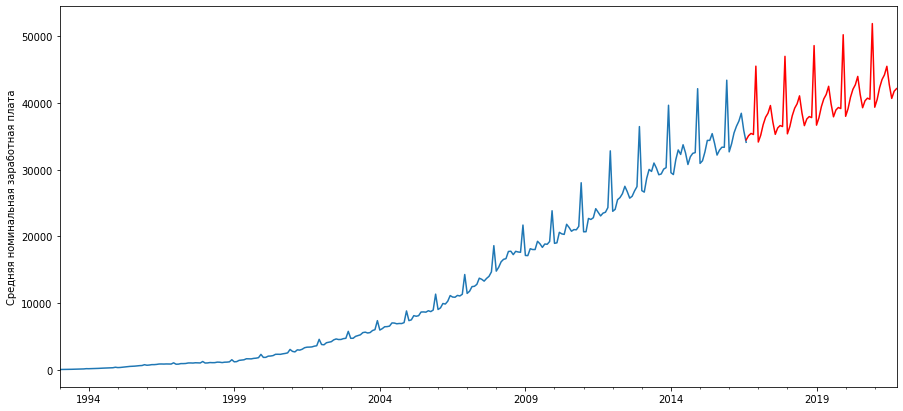

In [54]:
wag_c_m_2 = wag_c_m[["WAG_C_M"]]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,62)]
future = pd.DataFrame(index=date_list, columns= wag_c_m_2.columns)
wag_c_m_2 = pd.concat([wag_c_m_2, future])
wag_c_m_2["forecast"] = invboxcox(best_model.predict(start=283, end=284+62), lmbda)

plt.figure(figsize(15,7))
wag_c_m_2["WAG_C_M"].plot()
wag_c_m_2["forecast"].plot(color='r')
plt.ylabel("Средняя номинальная заработная плата")
plt.show()

Полученная модель хорошо уловила сезонность и общий тренд, предсказение модели выглядит правдоподобным.

**Дополнительно:** Валидация прогноза модели на реальных данных

В предложенном файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. На данный момент на сайте [Единного архива экономических
и социологических данных](http://sophist.hse.ru/hse/1/tables/WAG_M.htm) доступны данные вплоть до ноября 2021 года. Проверим насколько точным был полученный прогноз.

In [55]:
wag_c_m_2021 = pd.read_excel("data\WAG_C_M_2021.xls", index_col=None)
wag_c_m_2["WAG_C_M_2021_10"] = wag_c_m_2021["WAG_C_M"].values

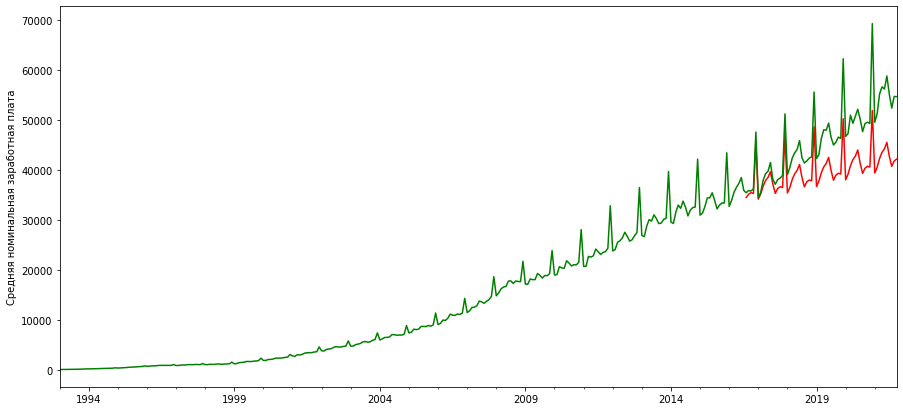

In [57]:
plt.figure(figsize(15,7))
wag_c_m_2["forecast"].plot(color='r')
wag_c_m_2["WAG_C_M_2021_10"].plot(color='g')
plt.ylabel("Средняя номинальная заработная плата")
plt.show()

По итогу видно сильное расхождение прогноза с реальными данными, что может говорить о влиянии факторов, которые в модели не учтены, либо можно поставить под сомнение предложенные статитстические данные. 